# Nullwerte

Wie wir bereits in der Übersicht zuvor gesehen haben, hat nicht jede Spalte für jede Zeile einen Wert.
Solche Werte werden auch als NaN ('Not a Number') bezeichnet, man spricht auch von fehlenden Werten. Nullwerte können das Training von ML Algorithmen negativ beeinflussen. Daher müssen wir mit diesen Daten auf besondere Weise umgehen. Folgende Möglichkeiten stehen zur Verfügung:

1. Datensätze entfernen
2. Ersetzen durch Median/Mittelwert/Mode
3. Eine eigene Kategorie zuweisen
4. Fehlende Werte schätzen

In [1]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
print(check_output(["ls", "../data/house-prices-advanced-regression-techniques"]).decode("utf8")) #check the files available in the directory

import pickle

data_description.txt
test.csv
test.pkl
train.csv
train.pkl


# Daten aus dem vorigen Schritt laden


In [2]:
with open('../data/house-prices-advanced-regression-techniques/train.pkl', 'rb') as handle:
    train = pickle.load(handle)

with open('../data/house-prices-advanced-regression-techniques/test.pkl', 'rb') as handle:
    test = pickle.load(handle)

# Daten zusammenfassen
Für die Identifikation von Nullwerten sollen Testdaten und Traindaten zusammen betrachtet werden, da z.B. Spalten entfernt und kategorische Daten diskretisiert werden sollen

In [3]:
ntrain = train.shape[0] # Anzahl der Trainingsdaten
ntest = test.shape[0]   # Anzahl der Testdaten

# Zielvariable der Trainingsdaten
y_train = train.SalePrice.values

# Index neu erstellen:
df = pd.concat((train, test)).reset_index(drop=True)

# Zielvariable aus den Features entfernen
df.drop(['SalePrice'], axis=1, inplace=True)

# Ergebnis
print("Dimensionen der gesamten Daten: {}".format(df.shape))

Dimensionen der gesamten Daten: (2919, 80)


In [4]:
# Anzahl der Nullwerte aller Spalten (Ergebnis ist kein DataFrame, sondern ein Series Objekt, leider...):
null_werte = df.isna().sum()

# Rück-Umwandeln in einen Data Frame
nan = pd.DataFrame(null_werte).set_axis(['count'], axis=1)

# Zeige alle Spalten, die Null-Werte haben, sortiert nach Spaltenname:
nan = nan[nan['count'] >0]
nan.sort_index(inplace=True)
nan

,count
Alley,2721
BsmtCond,82
BsmtExposure,82
BsmtFinSF1,1
BsmtFinSF2,1
BsmtFinType1,79
BsmtFinType2,80
BsmtFullBath,2
BsmtHalfBath,2
BsmtQual,81


In [5]:
# Zeige alle Spalten, die Null-Werte haben, sortiert nach Anzahl
nan.sort_values(by = 'count') 

,count
SaleType,1
KitchenQual,1
BsmtFinSF1,1
BsmtFinSF2,1
GarageCars,1
GarageArea,1
TotalBsmtSF,1
Exterior2nd,1
Exterior1st,1
BsmtUnfSF,1


### Beurteilung der Spalten mit Null-Werten:
Wir können der Datensatzbeschreibung entnehmen:

- Alley: Type of alley access to property == Art des Wegs, der zum Grundstück führt (Grvl, Pave, NA)
- BsmtCond: Evaluates the general condition of the basement == Qualität des Kellers (Ex, Gd, TA, Fa, Po, NA)
- BsmtExposure: Refers to walkout or garden level walls == Exposition des Kellers (Gd, Av, Mn, No, NA)
- BsmtFinSF1: Keller Typ 1, square feet
- BsmtFinSF2: Keller Typ 2, square feet
- BsmtFinType1: Rating of basement finished area == Qualität der Umgebung (GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA)
- BsmtFinType2: Rating of basement finished area == Qualität der Umgebung (GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA)
- BsmtFullBath: Anzahl Bäder im Keller
- BsmtHalfBath: Anzahl halbe Bäder im Keller
- BsmtQual: Qualität des Kellers (Ex, Gd, TA, Fa, Po, NA)
- BsmtUnfSF: Unfertiger Keller: square feet
- Electrical: Art der elektrischen Installation (SBrkr, FuseA, FuseF, FuseP, Mix)
- Exterior1st: Oberfläche des Hauses (AsbShng, AsphShn, BrkComm, BrkFace, CBlock, CemntBd, HdBoard, ImStucc, MetalSd, Other, Plywood, PreCast, Stone, Stucco, VinylSd, Wd Sdng, WdShing	Wood Shingles)
- Exterior2nd: Oberfläche des Hauses (AsbShng, AsphShn, BrkComm, BrkFace, CBlock, CemntBd, HdBoard, ImStucc, MetalSd, Other, Plywood, PreCast, Stone, Stucco, VinylSd, Wd Sdng, WdShing	Wood Shingles)
- Fence: Fence quality == Hellhörigkeit (GdPrv, MnPrv, GdWo, MnWw, NA)
- FireplaceQu: Fireplace quality == Qualität des Kamins/Ofens (Ex, Gd, TA, Fa, Po, NA)
- Functional: Hausfunktion (Typ, Min1, Min2, Mod, Maj1, Maj2, Sev, Sal)
- GarageArea: Größe der Garage
- GarageCars: Anzahl der Fahrzeuge der Garage
- GarageCond: Zustand der Garage (Ex, Gd, TA, Fa, Po, NA)
- GarageFinish: Oberflächen in der Garage (Fin, RFn, Unf, NA) 
- GarageQual: Qualität der Garage (Ex, Gd, TA, Fa, Po, NA)
- GarageType: Art der Garage (2Types, Attchd, Basment, BuiltIn, CarPort, Detchd, NA)
- GarageYrBlt: Baujahr der Garage
- KitchenQual: Ex, Gd, TA, Fa, Po
- LotFrontage: Linear feet of street connected to property == Breite der Straßenfront in Metern
- MasVnrArea: Verblendete Fläche in Quadratmetern
- MasVnrType: Masonry veneer type == Art der Mauerwerksverblendung (BrkCmn, BrkFace, CBlock, None, Stone)
- MiscFeature: Miscellaneous feature not covered in other categories == Weitere Eigenschaften (Elev, Gar2, Othr, Shed, TenC, NA)
- MSZoning: Umgebung (A, C, FV, I, RH, RL, RP, RM)
- PoolQC: Pool quality == Qualität des Pools (Ex, Gd, TA, Fa, NA)
- SaleType: Art des Verkaufs (WD , CWD, VWD, New, COD, Con, ConLw, ConLI, ConLD, Oth)
- TotalBsmtSF: Gesamtgröße des Kellers in square feet
- Utilities: Vorhandene Infrastruktur (AllPub, NoSewr, NoSeWa, ELO)

Hiervon sind numerische kontinuierliche Daten:
* LotFrontage
* MasVnrArea

* BsmtFinSF1
* BsmtFinSF2
* BsmtUnfSF
* GarageArea
* TotalBsmtSF

Hiervon sind numerische diskrete Daten
* BsmtFullBath
* BsmtHalfBath
* GarageCars

Hiervon sind kategorisch nominale Daten:
* Alley
* BsmtExposure
* Electrical
* GarageFinish
* GarageType
* MasVnrType
* MiscFeature

* Exterior1st
* Exterior2nd
* Functional
* MSZoning
* SaleType
* Utilities

Hiervon sind kategorisch ordninale Daten:
* FireplaceQu
* PoolQC
* Fence
* BsmtCond
* BsmtFinType1
* BsmtFinType2
* BsmtQual
* GarageCond
* GarageQual
* GarageYrBlt

* KitchenQual
* 


### Strategie zum Ersetzen von Nullwerten:
**Hiervon sind numerische kontinuierliche Daten:**
* LotFrontage => Durchschnitt aller nicht-Null-Werte
* MasVnrArea => Durchschnitt aller nicht-Null-Werte

* BsmtFinSF1 => 0 (wir nehmen an, dass es keinen Keller gibt)
* BsmtFinSF2 => 0
* BsmtUnfSF => 0
* GarageArea => 0 (wir nehemn an, dass es keine Garage gibt)
* TotalBsmtSF => 0

**Hiervon sind numerische diskrete Daten**
* BsmtFullBath => 0 (s.o.)
* BsmtHalfBath => 0
* GarageCars => 0 (s.o.)

**Hiervon sind kategorisch nominale Daten:**
Bei nominalen Daten besteht die Schwierigkeit, dass hier ein sinnvoller Ersatzwert gefunden werden muss, wenn die Datenzeilen nicht ganz gelöscht werden sollen.
Da alle diese kategorische nominalen Daten ein NA für nicht verfügbar aufweisen, kann durch NA (bzw. None bei MasVnrType) ersetzt werden.
* Alley
* BsmtExposure
* GarageFinish
* GarageType
* MasVnrType
* MiscFeature

* Exterior1st => mode
* Exterior2nd => mode
* Functional => Sonderfall: Wir können laut Datenbeschreibung 'Typ' als Wert für NaN verwenden. all_data["Functional"] = all_data["Functional"].fillna("Typ")
* Electrical => mode
* MSZoning => mode
* SaleType => mode
* Utilities => drop column

**Hiervon sind kategorisch ordninale Daten:**
Auch hier kann jeweils 'NA' angenommen werden. Für GarageYrBlt wird 1900 angenommen (s.u.)
* FireplaceQu
* PoolQC
* Fence
* BsmtCond
* BsmtFinType1
* BsmtFinType2
* BsmtQual
* GarageCond
* GarageQual
* GarageYrBlt

* KitchenQual => mode

### Auffällig sind die Spalten mit Garagen
Alle Garagen-Spalten haben genau 81 NaN Zeilen. Offenbar sind dies die Objekte ohne Garage.
Hier sieht die Ersatz-Strategie so aus, dass überall NA als Wert angenommen wird. GarageYrBlt wird als 1900 angenommen, unter der Hypothese, dass je älter die Garage, desto schlechter. Das korreliert mit dem Fehlen der Garage.

In [6]:
cols = ['GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt']
df_gar = df [cols].copy()
df_gar[df_gar['GarageCond'].isna()]

,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
39,0.000,NaN,NaN,NaN,NaN,NaN
48,0.000,NaN,NaN,NaN,NaN,NaN
78,0.000,NaN,NaN,NaN,NaN,NaN
88,0.000,NaN,NaN,NaN,NaN,NaN
89,0.000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2893,0.000,NaN,NaN,NaN,NaN,NaN
2909,0.000,NaN,NaN,NaN,NaN,NaN
2913,0.000,NaN,NaN,NaN,NaN,NaN
2914,0.000,NaN,NaN,NaN,NaN,NaN


## Umsetzung

Zunächst sehen wir uns noch einmal die Häufigkeit der Nullwerte an:

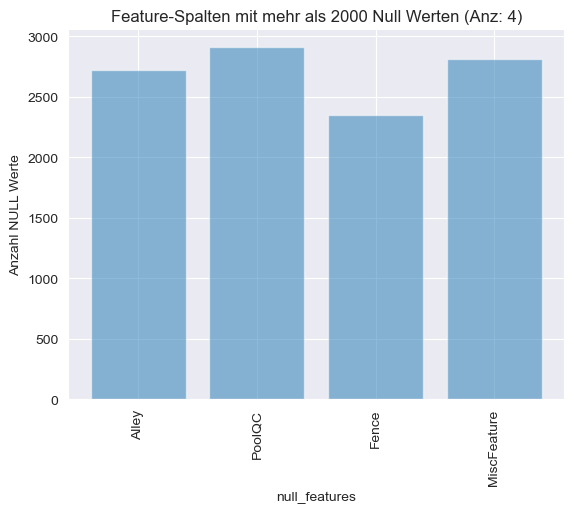

In [7]:
#Drucke alle Nan-Spalten in einem Bar-Chart

null_features = []
nullValues = []
threshold = 2000
for i in df:
    # print (i + ": " + str(df.isna().sum()[i]))
    if (df.isna().sum()[i])>threshold and i!='SalePrice':
        null_features.append(i)
        nullValues.append(df.isna().sum()[i])
        
y_pos = np.arange(len(null_features)) 
plt.bar(y_pos, nullValues, align='center', alpha=0.5)
plt.xticks(y_pos, null_features)
plt.ylabel('Anzahl NULL Werte')
plt.xlabel('null_features')
plt.title('Feature-Spalten mit mehr als ' + str (threshold) +' Null Werten (Anz: ' + str (len(nullValues)) + ')')
plt.xticks(rotation=90)
plt.show()

In [8]:
# Beispieldaten unserer betroffenen Spalten
print (null_features)
null_df = df[null_features]
null_df.head()

['Alley', 'PoolQC', 'Fence', 'MiscFeature']


,Alley,PoolQC,Fence,MiscFeature
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


### Unterscheidung der Fälle

In [25]:
#Numerische kontinuierliche Daten:
num_kon_cols = ['LotFrontage', 'MasVnrArea']

#Spalten, für die NaN auf 0 gesetzt werden kann:
num_cols_zero = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageArea', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars']

#Spalten, die mit dem häufigsten Wert belegt werden können:
set_col_to_mode = ['KitchenQual', 'SaleType', 'MSZoning', 'Electrical', 'Exterior2nd', 'Exterior1st']

#Kategorisch nominale Daten:
kat_nom_cols = ['BsmtExposure', 'GarageFinish', 'GarageType']

#Kategorisch ordninale Daten:
kat_ord_cols = ['FireplaceQu', 'Fence', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'GarageCond', 'GarageQual']


#TODO: Es wurden in den Listen die vier "null_feature" Spalten manuell entfernt. Das könnte man automatisieren.

### Wir betrachten zunächst die Sonderfälle:

In [10]:
# Wir arbeiten auf einer Kopie!
df_processed = df.copy()


df_processed['GarageYrBlt'] = df_processed['GarageYrBlt'].fillna('1900')

df_processed['MasVnrType'] = df_processed['MasVnrType'].fillna('None')

df_processed["Functional"] = df_processed['Functional'].fillna("Typ")


## Spalten löschen


### Die Null-Feature Spalten (mehr als threshold Werte) entfernen wir aus dem Dataset:


In [11]:
df_processed = df_processed.dropna(axis=1, thresh =  df.shape[0] - threshold) # Threshold -> Anzahl der NICHT-NaN Zeilen

print("Spaltenzahl Original Datenset: " + str (df.shape[1]))
print("Spaltenzahl processed Datenset: " + str (df_processed.shape[1]))


Spaltenzahl Original Datenset: 80
Spaltenzahl processed Datenset: 76


### Spalte 'Utilities' löschen

In [12]:
df_processed = df_processed.drop(['Utilities'], axis=1)

### Für einige Spalten setzen wir default-Werte - Spalten mit mean()

In [13]:
df_processed[num_kon_cols].mean()

LotFrontage    69.306
MasVnrArea    102.201
dtype: float64

In [14]:
# numerisch kontinuierliche Daten:

print(df_processed[num_kon_cols].isna().sum())
for col in num_kon_cols:
    df_processed[col] = df_processed[col].fillna(df_processed[col].mean())

df_processed[num_kon_cols].isna().sum()


LotFrontage    486
MasVnrArea      23
dtype: int64


LotFrontage    0
MasVnrArea     0
dtype: int64

### Spalten, die mit dem häufigsten Wert belegt werden - Spalten mit mode()

In [15]:
for col in set_col_to_mode:
    print (col, df[col].mode()[0])
    df[col] = df[col].fillna(df[col].mode()[0])

KitchenQual TA
SaleType WD
MSZoning RL
Electrical SBrkr
Exterior2nd VinylSd
Exterior1st VinylSd


### Numerische Daten, die auf 0 gesetzt werden können:

In [16]:
for col in num_cols_zero:
    print(col)
    df[col] = df[col].fillna(0)

BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
GarageArea
TotalBsmtSF
BsmtFullBath
BsmtHalfBath
GarageCars


### Kategorisch nominale und ordinale Daten, die auf 'NA' gesetzt werden können

In [19]:
# kategorisch nominale Daten, die auf NA gesetzt werden können:

for col in kat_nom_cols:
    print(col)
    df_processed[col] = df_processed[col].fillna('NA')


BsmtExposure
GarageFinish
GarageType


In [24]:
# kategorisch ordinale Daten, die auf NA gesetzt werden können:

for col in kat_ord_cols:
    print(col)
    df_processed[col] = df_processed[col].fillna('NA')



FireplaceQu
PoolQC


KeyError: 'PoolQC'

# Überprüfung

In [21]:
# Anzahl der Nullwerte aller Spalten (Ergebnis ist kein DataFrame, sondern ein Series Objekt, leider...):
null_werte = df_processed.isna().sum()

# Rück-Umwandeln in einen Data Frame
nan = pd.DataFrame(null_werte).set_axis(['count'], axis=1)
nan

,count
Id,0
MSSubClass,0
MSZoning,4
LotFrontage,0
LotArea,0
...,...
MiscVal,0
MoSold,0
YrSold,0
SaleType,1


In [ ]:
with open('../output/titanic/datasets.pkl', 'wb') as handle:
    pickle.dump(datasets, handle)